
 PERFORMANCE REPORT: Adaptive Spread Strategy (Submission Ready)


,Quarter,Gross SR,Net SR,Net CR,Gross CumP&L,Net CumP&L,Av. Trades,Stat
0,2023_Q1,3.645410,1.322012,3.895737,8987.30,3131.30,2.741573,0.938284
1,2023_Q3,2.352859,0.226410,0.451500,5346.00,498.00,2.269663,-0.000000
2,2023_Q4,3.259013,0.921792,2.478263,5422.68,1534.68,1.820225,0.180663
3,2024_Q2,-1.429687,-3.175491,-2.535123,-3128.25,-7016.25,1.820225,-7.160699
4,2024_Q4,0.330229,-1.377546,-1.448646,795.39,-3332.61,1.869565,-2.260107
5,2025_Q1,0.505040,-0.580522,-0.945441,1635.94,-1868.06,1.640449,-0.675219
6,2025_Q2,0.128436,-0.935788,-1.268934,469.66,-3418.34,1.780220,-1.764806



TOTAL RANKING SCORE: -10.7419


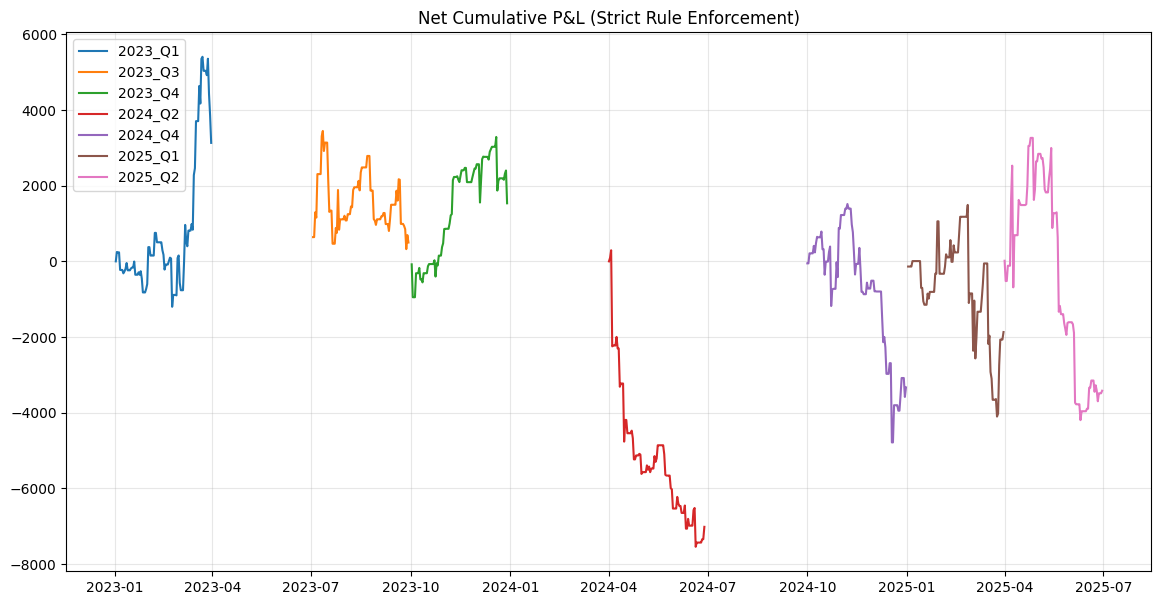

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # 提出用パス (dataフォルダ内の各クォータファイル)
    QUARTERS = ['2023_Q1', '2023_Q3', '2023_Q4', '2024_Q2', '2024_Q4', '2025_Q1', '2025_Q2']
    ASSETS = ['SP', 'NQ']

    SPECS = {
        'SP': {'point_val': 50.0, 'cost': 12.0},
        'NQ': {'point_val': 20.0, 'cost': 12.0}
    }

    # === Trading Hours & Constraints (Mandatory) ===
    # do not trade within 9:31-9:55
    TRADE_START_TIME = pd.to_datetime("09:56").time()
    # exit all positions 20 minutes before end (15:40)
    EXIT_TIME = pd.to_datetime("15:40").time()

    # Strategy Parameters
    WINDOW = 45
    BETA_WINDOW = 600
    VOL_WINDOW = 180
    VOL_BASELINE_WINDOW = 600
    BASE_Z_ENTRY = 3.0   # 厳格化
    STOP_LOSS_Z = 5.0

    Z_EXIT = 0.0

    ADAPTIVE_SENSITIVITY = 0.5
    MAX_Z_ENTRY = 3.5
    ANNUALIZATION = 252

    last_exit_time = None
    COOLDOWN_MINUTES = 30

# ==========================================
# 2. Strategy Engine (Per-Quarter Logic)
# ==========================================
def run_strategy_on_quarter(quarter_name, cfg):
    # 1. Load Data
    try:
        df = pd.read_parquet(f'data/data1_{quarter_name}.parquet')
    except:
        return None
    
    df.set_index('datetime', inplace=True)
    
    # 2. Apply Professor's Mandatory Data Cleaning
    # 9:31-9:40 and 15:51-16:00 are NaNs
    df.loc[df.between_time("09:31", "09:40").index] = np.nan
    df.loc[df.between_time("15:51", "16:00").index] = np.nan

    # 3. Strategy Indicators (Strictly within the quarter - no look-back)
    ln_sp = np.log(df['SP'])
    ln_nq = np.log(df['NQ'])
    
    nq_ret = ln_nq.diff()
    current_vol = nq_ret.rolling(window=cfg.VOL_WINDOW).std()
    baseline_vol = nq_ret.rolling(window=cfg.VOL_BASELINE_WINDOW).std()
    vol_ratio = (current_vol / baseline_vol.replace(0, np.nan)).fillna(1.0)
    
    cov = ln_nq.rolling(window=cfg.BETA_WINDOW).cov(ln_sp)
    var = ln_sp.rolling(window=cfg.BETA_WINDOW).var()
    beta_lag = (cov / var).shift(1).fillna(1.0)
    
    spread = ln_nq - (beta_lag * ln_sp)
    z_score = (spread - spread.rolling(window=cfg.WINDOW).mean()) / spread.rolling(window=cfg.WINDOW).std().replace(0, np.nan)

    # 4. Iterative Backtest Loop
    times = df.index.time
    z_vals = z_score.values
    vol_vals = vol_ratio.values
    pos_strategy = np.zeros(len(df))
    curr_pos = 0

    for i in range(len(df)):
        # Mandatory Rules
        if times[i] < cfg.TRADE_START_TIME or times[i] >= cfg.EXIT_TIME:
            curr_pos = 0
            pos_strategy[i] = 0
            continue
            
        if np.isnan(z_vals[i]) or np.isnan(vol_vals[i]):
            pos_strategy[i] = curr_pos
            continue
            
        # Entry/Exit Logic
        extra = max(0, (vol_vals[i] - 1.0) * cfg.ADAPTIVE_SENSITIVITY)
        entry_z = min(cfg.BASE_Z_ENTRY + extra, cfg.MAX_Z_ENTRY)
        z = z_vals[i]
    
        if curr_pos == 0:
            if z > entry_z: curr_pos = -1
            elif z < -entry_z: curr_pos = 1
        elif curr_pos == 1:
            if z >= cfg.Z_EXIT: curr_pos = 0
            elif z < -cfg.STOP_LOSS_Z: curr_pos = 0 # 損切り
        elif curr_pos == -1:
            if z <= -cfg.Z_EXIT: curr_pos = 0
            elif z > cfg.STOP_LOSS_Z: curr_pos = 0
                
        pos_strategy[i] = curr_pos

    # 5. PnL Calculation
    pos_held = pd.Series(pos_strategy, index=df.index).shift(1).fillna(0)
    # Re-enforce exit rule on shifted position
    pos_held[times >= cfg.EXIT_TIME] = 0
    
    pnl_gross = (pos_held * df['NQ'].diff() * cfg.SPECS['NQ']['point_val']) + \
                (pos_held * -1 * df['SP'].diff() * cfg.SPECS['SP']['point_val'])
    
    ntrans = pos_held.diff().abs().fillna(0)
    cost = ntrans * (cfg.SPECS['NQ']['cost'] + cfg.SPECS['SP']['cost'])
    pnl_net = pnl_gross.fillna(0) - cost
    
    # Return Daily Series for Aggregation
    daily = pd.DataFrame({
        'Gross_PnL': pnl_gross.resample('D').sum(),
        'Net_PnL': pnl_net.resample('D').sum(),
        'Trades': ntrans.resample('D').sum()
    }).dropna(how='all')
    
    daily['Quarter'] = quarter_name
    return daily

# ==========================================
# 3. Execution & Reporting (Original Style)
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    all_daily = []

    for q in cfg.QUARTERS:
        res = run_strategy_on_quarter(q, cfg)
        if res is not None:
            all_daily.append(res)

    full_daily = pd.concat(all_daily)

    # Quarterly Statistics Calculation
    stats_list = []
    for q in cfg.QUARTERS:
        d_q = full_daily[full_daily['Quarter'] == q]
        
        net_cum = d_q['Net_PnL'].sum()
        net_sr = (d_q['Net_PnL'].mean() / d_q['Net_PnL'].std() * np.sqrt(cfg.ANNUALIZATION)) if d_q['Net_PnL'].std() != 0 else 0
        
        # Stat calculation
        abs_pnl_scaled = abs(net_cum) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        stat = (net_sr - 0.5) * max(0, log_term)

        # Max Drawdown for Calmar
        equity = d_q['Net_PnL'].cumsum()
        max_dd = (equity.cummax() - equity).max()
        years = len(d_q) / cfg.ANNUALIZATION
        net_cr = (net_cum / years / max_dd) if max_dd > 0 else 0

        stats_list.append({
            'Quarter': q,
            'Gross SR': (d_q['Gross_PnL'].mean() / d_q['Gross_PnL'].std() * np.sqrt(cfg.ANNUALIZATION)),
            'Net SR': net_sr,
            'Net CR': net_cr,
            'Gross CumP&L': d_q['Gross_PnL'].sum(),
            'Net CumP&L': net_cum,
            'Av. Trades': d_q['Trades'].mean(),
            'Stat': stat
        })

    stats_df = pd.DataFrame(stats_list)
    
    print("\n" + "=" * 80)
    print(" PERFORMANCE REPORT: Adaptive Spread Strategy (Submission Ready)")
    print("=" * 80)
    display(stats_df)
    print(f"\nTOTAL RANKING SCORE: {stats_df['Stat'].sum():.4f}")

    # Plot (Original Style: Reset per Quarter)
    plt.figure(figsize=(14, 7))
    for q in cfg.QUARTERS:
        d_q = full_daily[full_daily['Quarter'] == q]
        plt.plot(d_q.index, d_q['Net_PnL'].cumsum(), label=q)
    
    plt.title('Net Cumulative P&L (Strict Rule Enforcement)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()



 PERFORMANCE REPORT: Adaptive Spread Strategy (Submission Ready)


,Quarter,Gross SR,Net SR,Net CR,Gross CumP&L,Net CumP&L,Av. Trades,Stat
0,2023_Q1,4.220471,2.192343,8.427571,9041.67,4529.67,2.112360,2.556536
1,2023_Q3,1.867381,-0.015691,-0.023004,3904.10,-31.90,1.842697,-0.000000
2,2023_Q4,3.421694,1.175249,3.080049,5603.34,1907.34,1.730337,0.436015
3,2024_Q2,-0.429618,-2.196067,-2.377874,-843.54,-4299.54,1.617978,-3.932235
4,2024_Q4,1.066655,-0.575434,-0.516183,2307.47,-1244.53,1.608696,-0.235260
5,2025_Q1,1.165788,0.173778,0.290636,3826.56,562.56,1.528090,-0.000000
6,2025_Q2,2.967869,1.711968,3.592964,8363.07,4715.07,1.670330,1.879476



TOTAL RANKING SCORE: 0.7045


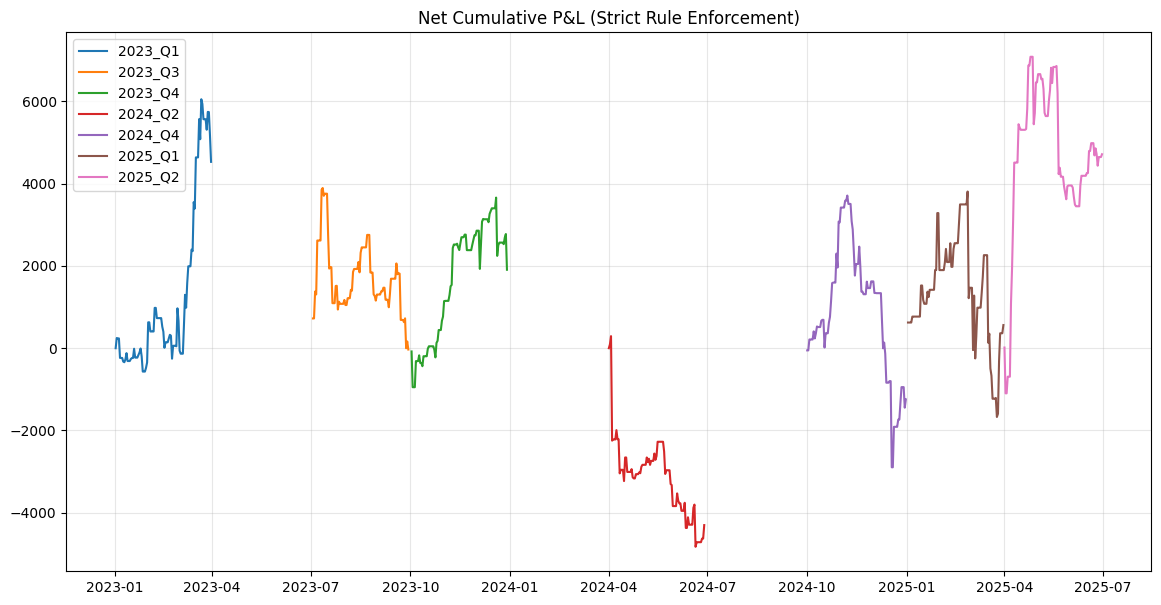

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. Configuration
# ==========================================
class Config:
    QUARTERS = ['2023_Q1', '2023_Q3', '2023_Q4', '2024_Q2', '2024_Q4', '2025_Q1', '2025_Q2']
    ASSETS = ['SP', 'NQ']

    SPECS = {
        'SP': {'point_val': 50.0, 'cost': 12.0},
        'NQ': {'point_val': 20.0, 'cost': 12.0}
    }

    # === Trading Hours ===
    # ノイズを避けるため開始を10:00に設定
    TRADE_START_TIME = pd.to_datetime("10:00").time()
    EXIT_TIME = pd.to_datetime("15:40").time()

    # Strategy Parameters
    WINDOW = 45
    BETA_WINDOW = 600
    VOL_WINDOW = 180
    VOL_BASELINE_WINDOW = 600
    BASE_Z_ENTRY = 3.0   
    STOP_LOSS_Z = 5.0
    Z_EXIT = 0.0

    ADAPTIVE_SENSITIVITY = 0.5
    MAX_Z_ENTRY = 3.5
    ANNUALIZATION = 252
    
    # 冷却期間の設定
    COOLDOWN_MINUTES = 30

# ==========================================
# 2. Strategy Engine (Per-Quarter Logic)
# ==========================================
def run_strategy_on_quarter(quarter_name, cfg):
    try:
        df = pd.read_parquet(f'data/data1_{quarter_name}.parquet')
    except:
        return None
    
    df.set_index('datetime', inplace=True)
    
    df.loc[df.between_time("09:31", "09:40").index] = np.nan
    df.loc[df.between_time("15:51", "16:00").index] = np.nan

    ln_sp = np.log(df['SP'])
    ln_nq = np.log(df['NQ'])
    
    nq_ret = ln_nq.diff()
    current_vol = nq_ret.rolling(window=cfg.VOL_WINDOW).std()
    baseline_vol = nq_ret.rolling(window=cfg.VOL_BASELINE_WINDOW).std()
    vol_ratio = (current_vol / baseline_vol.replace(0, np.nan)).fillna(1.0)
    
    cov = ln_nq.rolling(window=cfg.BETA_WINDOW).cov(ln_sp)
    var = ln_sp.rolling(window=cfg.BETA_WINDOW).var()
    beta_lag = (cov / var).shift(1).fillna(1.0)
    
    spread = ln_nq - (beta_lag * ln_sp)
    z_score = (spread - spread.rolling(window=cfg.WINDOW).mean()) / spread.rolling(window=cfg.WINDOW).std().replace(0, np.nan)

    # --- 4. Iterative Backtest Loop (MODIFIED) ---
    times = df.index.time
    datetimes = df.index # 冷却期間計算のために必要
    z_vals = z_score.values
    vol_vals = vol_ratio.values
    pos_strategy = np.zeros(len(df))
    curr_pos = 0
    
    # 四半期ごとにリセット
    last_exit_time = None 

    for i in range(len(df)):
        # Mandatory Rules
        if times[i] < cfg.TRADE_START_TIME or times[i] >= cfg.EXIT_TIME:
            if curr_pos != 0:
                last_exit_time = datetimes[i] # 強制決済時も時刻を記録
            curr_pos = 0
            pos_strategy[i] = 0
            continue
            
        if np.isnan(z_vals[i]) or np.isnan(vol_vals[i]):
            pos_strategy[i] = curr_pos
            continue
            
        # 冷却期間のチェック
        is_cooldown = False
        if last_exit_time is not None:
            diff_min = (datetimes[i] - last_exit_time).total_seconds() / 60
            if diff_min < cfg.COOLDOWN_MINUTES:
                is_cooldown = True

        # Entry/Exit Logic
        extra = max(0, (vol_vals[i] - 1.0) * cfg.ADAPTIVE_SENSITIVITY)
        entry_z = min(cfg.BASE_Z_ENTRY + extra, cfg.MAX_Z_ENTRY)
        z = z_vals[i]
    
        if curr_pos == 0:
            # 冷却期間中でない場合のみエントリー
            if not is_cooldown:
                if z > entry_z: 
                    curr_pos = -1
                elif z < -entry_z: 
                    curr_pos = 1
        
        elif curr_pos == 1:
            if z >= cfg.Z_EXIT or z < -cfg.STOP_LOSS_Z:
                curr_pos = 0
                last_exit_time = datetimes[i] # 決済時刻を記録
        
        elif curr_pos == -1:
            if z <= -cfg.Z_EXIT or z > cfg.STOP_LOSS_Z:
                curr_pos = 0
                last_exit_time = datetimes[i] # 決済時刻を記録
                
        pos_strategy[i] = curr_pos

    # --- 以降の計算部分は以前と同じ ---
    pos_held = pd.Series(pos_strategy, index=df.index).shift(1).fillna(0)
    pos_held[times >= cfg.EXIT_TIME] = 0
    
    pnl_gross = (pos_held * df['NQ'].diff() * cfg.SPECS['NQ']['point_val']) + \
                (pos_held * -1 * df['SP'].diff() * cfg.SPECS['SP']['point_val'])
    
    ntrans = pos_held.diff().abs().fillna(0)
    cost = ntrans * (cfg.SPECS['NQ']['cost'] + cfg.SPECS['SP']['cost'])
    pnl_net = pnl_gross.fillna(0) - cost
    
    daily = pd.DataFrame({
        'Gross_PnL': pnl_gross.resample('D').sum(),
        'Net_PnL': pnl_net.resample('D').sum(),
        'Trades': ntrans.resample('D').sum()
    }).dropna(how='all')
    
    daily['Quarter'] = quarter_name
    return daily

# ==========================================
# 3. Execution & Reporting (Original Style)
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    all_daily = []

    for q in cfg.QUARTERS:
        res = run_strategy_on_quarter(q, cfg)
        if res is not None:
            all_daily.append(res)

    full_daily = pd.concat(all_daily)

    # Quarterly Statistics Calculation
    stats_list = []
    for q in cfg.QUARTERS:
        d_q = full_daily[full_daily['Quarter'] == q]
        
        net_cum = d_q['Net_PnL'].sum()
        net_sr = (d_q['Net_PnL'].mean() / d_q['Net_PnL'].std() * np.sqrt(cfg.ANNUALIZATION)) if d_q['Net_PnL'].std() != 0 else 0
        
        # Stat calculation
        abs_pnl_scaled = abs(net_cum) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        stat = (net_sr - 0.5) * max(0, log_term)

        # Max Drawdown for Calmar
        equity = d_q['Net_PnL'].cumsum()
        max_dd = (equity.cummax() - equity).max()
        years = len(d_q) / cfg.ANNUALIZATION
        net_cr = (net_cum / years / max_dd) if max_dd > 0 else 0

        stats_list.append({
            'Quarter': q,
            'Gross SR': (d_q['Gross_PnL'].mean() / d_q['Gross_PnL'].std() * np.sqrt(cfg.ANNUALIZATION)),
            'Net SR': net_sr,
            'Net CR': net_cr,
            'Gross CumP&L': d_q['Gross_PnL'].sum(),
            'Net CumP&L': net_cum,
            'Av. Trades': d_q['Trades'].mean(),
            'Stat': stat
        })

    stats_df = pd.DataFrame(stats_list)
    
    print("\n" + "=" * 80)
    print(" PERFORMANCE REPORT: Adaptive Spread Strategy (Submission Ready)")
    print("=" * 80)
    display(stats_df)
    print(f"\nTOTAL RANKING SCORE: {stats_df['Stat'].sum():.4f}")

    # Plot (Original Style: Reset per Quarter)
    plt.figure(figsize=(14, 7))
    for q in cfg.QUARTERS:
        d_q = full_daily[full_daily['Quarter'] == q]
        plt.plot(d_q.index, d_q['Net_PnL'].cumsum(), label=q)
    
    plt.title('Net Cumulative P&L (Strict Rule Enforcement)')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()